# Makemore Part 3: BatchNorm

Reference Paper #1: [Kaiming Initialization](https://arxiv.org/pdf/1502.01852.pdf)

Reference Paper #2: [Batch Normalization](https://arxiv.org/pdf/1502.03167.pdf)

[Video Checkpoint](https://youtu.be/P6sfmUTpUmc?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=6590)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read all words in 
words = open('names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(words)

32033

In [5]:
# mappings from characters to indices and vice versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s, in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos, vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 27


In [6]:
# build the dataset 
block_size = 3 # context length for neural net input

def build_dataset(words, block_size):
    X,Y = [],[]

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            X.append(context[:])
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1], block_size)    # 80%
X_valid, Y_valid = build_dataset(words[n1:n2], block_size)  # 10%
X_test, Y_test = build_dataset(words[n2:], block_size)      # 10%

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [7]:
# MLP Revisited

# Hyper parameters
n_embd = 10         # embedding dimensions
n_hidden = 200      # size of hidden layer
eta = 0.1          # learning rate
n_epochs = 10000    # number of epochs
batch_size = 32     # batch size

g = torch.Generator().manual_seed(2147473647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)        # embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)        # input layer
b1 = torch.randn((n_hidden,),                     generator=g)        # input bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # output layer
b2 = torch.randn((vocab_size,),                   generator=g) * 0.01 # output bias
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 11897


In [8]:
etas = []
losses = []

In [9]:
for epoch in range(n_epochs):
    # construct batches
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]]
    x = emb.view(emb.shape[0], -1)
    z_hidden = x @ W1 + b1

    # forward pass
    h = torch.tanh(z_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch {epoch:3d}: loss = {loss.item():.3f}")
    losses.append(loss.log10().item())

    # backward pass
    for p in parameters:
        p.grad = None # flush out gradients
    loss.backward()
    for p in parameters:
        p.data -= eta * p.grad if epoch < n_epochs // 2 else eta * p.grad * 0.01

Epoch   0: loss = 3.296
Epoch 1000: loss = 2.611
Epoch 2000: loss = 2.393
Epoch 3000: loss = 2.437
Epoch 4000: loss = 2.329
Epoch 5000: loss = 2.224
Epoch 6000: loss = 2.297
Epoch 7000: loss = 2.213
Epoch 8000: loss = 1.881
Epoch 9000: loss = 2.297


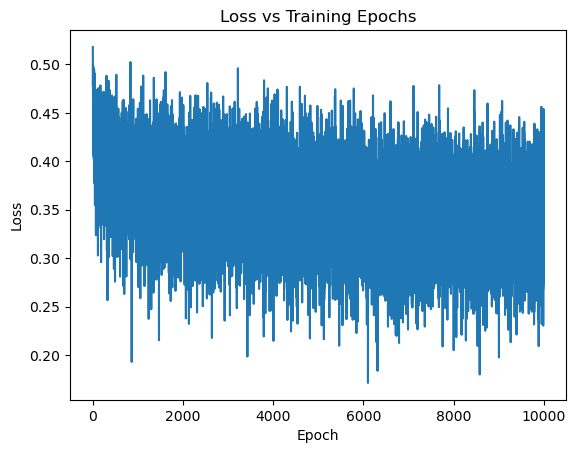

In [10]:
plt.title('Loss vs Training Epochs')
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_valid, Y_valid),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss = {loss.item():.3f}")
    return loss

split_loss('train')
split_loss('val')

train loss = 2.190
val loss = 2.456


tensor(2.4558)

## 1.2 Fixing the vanishing gradient issue with tanh

Notice below what the output of all the hidden layer neurons are

(array([2319.,  131.,   77.,   46.,   48.,   49.,   43.,   24.,   40.,
          44.,   29.,   25.,   16.,   26.,   19.,   30.,   22.,   17.,
          14.,   27.,   18.,   14.,   12.,   25.,   19.,   25.,   16.,
          20.,   10.,   22.,   17.,   23.,   33.,   19.,   12.,   21.,
          33.,   11.,   31.,   18.,   27.,   37.,   46.,   48.,   38.,
          56.,   55.,   94.,  140., 2414.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

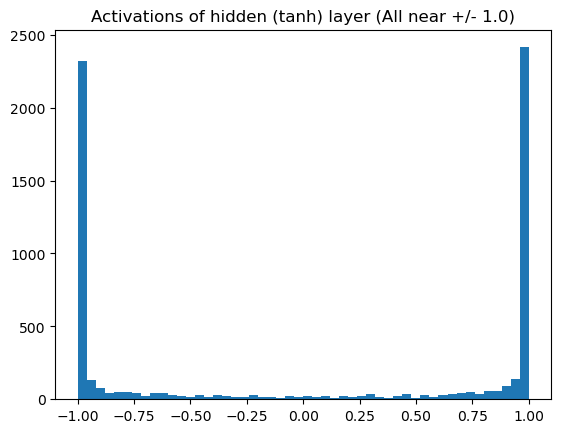

In [12]:
plt.title("Activations of hidden (tanh) layer (All near +/- 1.0)")
plt.hist(h.view(-1).tolist(), 50)

Text(0.5, 1.0, 'Input to hidden layer(Too wide)')

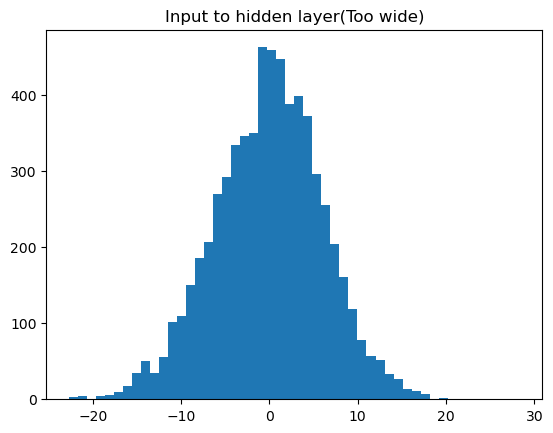

In [13]:
plt.hist(z_hidden.view(-1).tolist(), 50)
plt.title("Input to hidden layer(Too wide)")

Text(0.5, 1.0, 'Hidden layer (tanh) activations above 0.99')

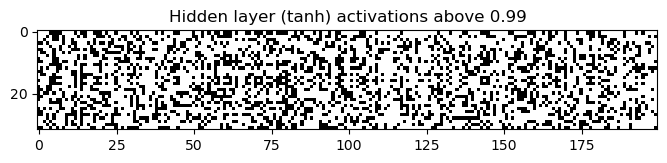

In [14]:
plt.figure(figsize=(8,6))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title("Hidden layer (tanh) activations above 0.99")

We can see that over half of the tanh neurons are above 0.99. which means they are in a nearly zero-gradient zone. As a result, the hidden layer and the input layer learn extremely slowly. We need to squash the input into the tanh function to be within $(-1,1)$

### 1.3 Fixing the vanishing gradient issue

tensor(-0.0006) tensor(1.0011)
tensor(0.0039) tensor(3.2039)



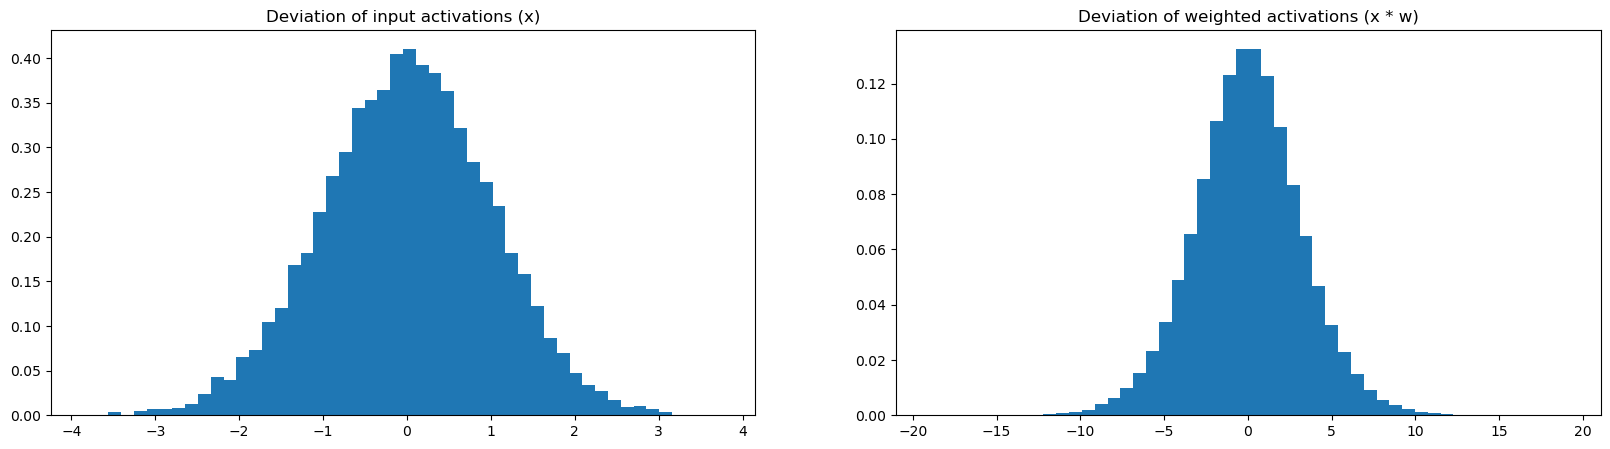

In [15]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("Deviation of input activations (x)")
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.title("Deviation of weighted activations (x * w)")
plt.hist(y.view(-1).tolist(), 50, density=True)
print() # remove output from previous action

Now, we will divide the weighted activations by the square root of the dimensionality of the input.

tensor(-0.0034) tensor(0.9930)
tensor(0.0012) tensor(0.9614)



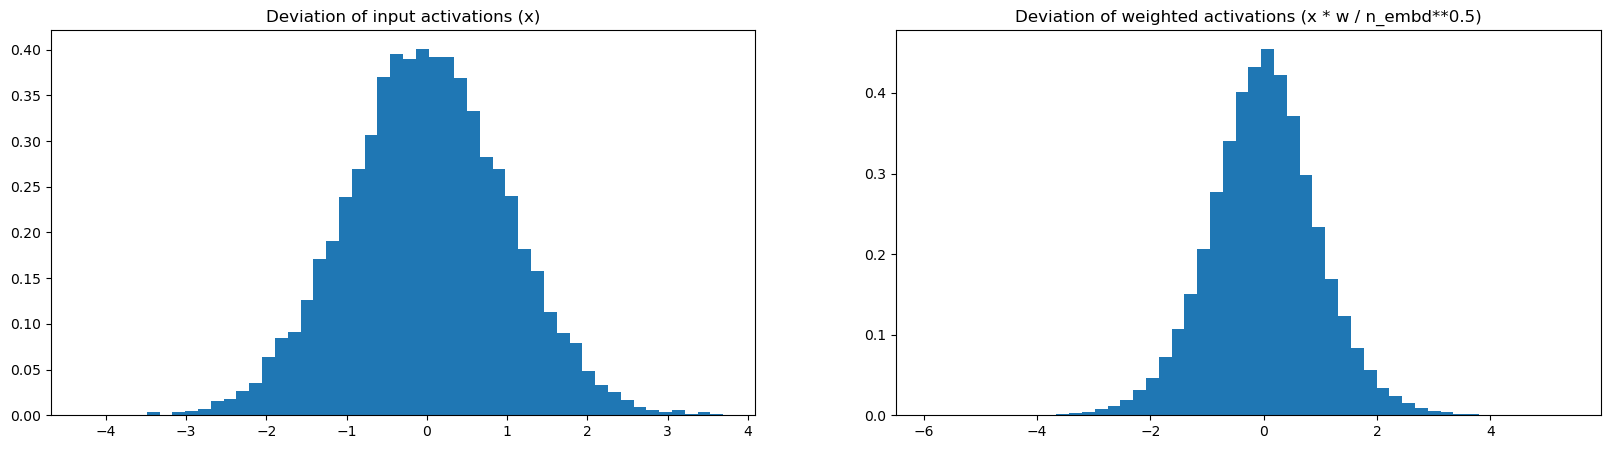

In [16]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / n_embd**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("Deviation of input activations (x)")
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.title("Deviation of weighted activations (x * w / n_embd**0.5)")
plt.hist(y.view(-1).tolist(), 50, density=True)
print() # remove output from previous action

In [17]:
# MLP Revisited

# Hyper parameters
n_embd = 10         # embedding dimensions
n_hidden = 200      # size of hidden layer
eta = 0.1          # learning rate
n_epochs = 10000    # number of epochs
batch_size = 32     # batch size

g = torch.Generator().manual_seed(2147473647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)        # embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1  # input layer
b1 = torch.randn((n_hidden,),                     generator=g) * 0.01 # input bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # output layer
b2 = torch.randn((vocab_size,),                   generator=g) * 0.01 # output bias
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 11897


In [18]:
etas = []
losses = []

In [19]:
for epoch in range(n_epochs):
    # construct batches
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]]
    x = emb.view(emb.shape[0], -1)
    z_hidden = x @ W1 + b1

    # forward pass
    h = torch.tanh(z_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch {epoch:3d}: loss = {loss.item():.3f}")
    losses.append(loss.log10().item())

    # backward pass
    for p in parameters:
        p.grad = None # flush out gradients
    loss.backward()
    for p in parameters:
        p.data -= eta * p.grad if epoch < n_epochs // 2 else eta * p.grad * 0.01

Epoch   0: loss = 3.293
Epoch 1000: loss = 2.417
Epoch 2000: loss = 2.103
Epoch 3000: loss = 2.157
Epoch 4000: loss = 2.200
Epoch 5000: loss = 2.568
Epoch 6000: loss = 2.391
Epoch 7000: loss = 1.816
Epoch 8000: loss = 2.290
Epoch 9000: loss = 2.291


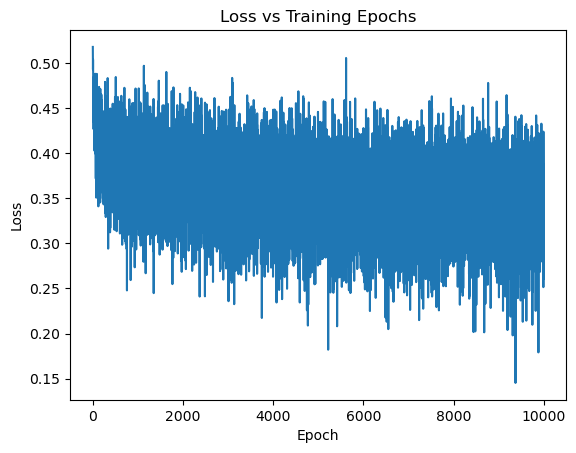

In [20]:
plt.title('Loss vs Training Epochs')
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

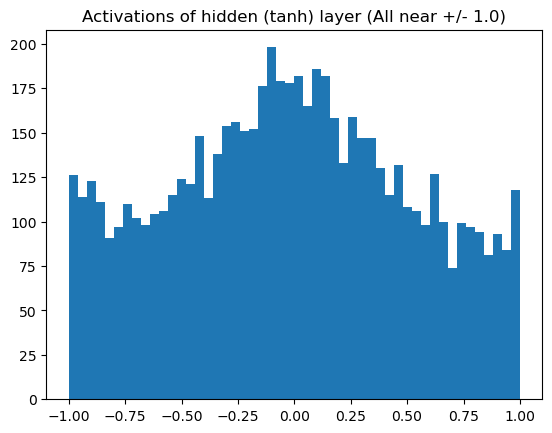

In [21]:
plt.title("Activations of hidden (tanh) layer (All near +/- 1.0)")
plt.hist(h.view(-1).tolist(), 50)
print() # remove the output of the previous action

Text(0.5, 1.0, 'Input to hidden layer(Too wide)')

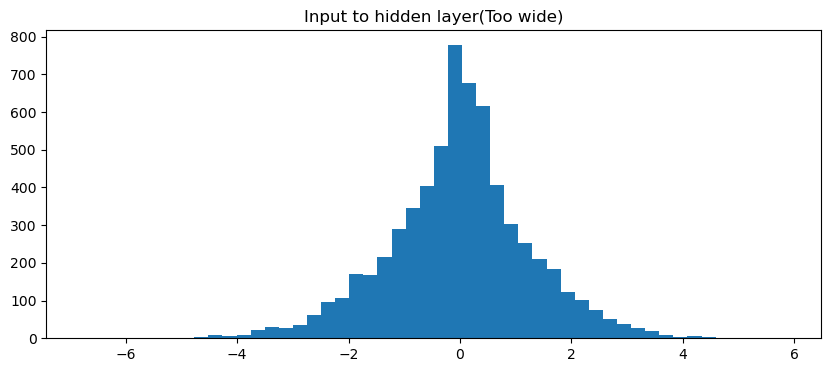

In [83]:
plt.figure(figsize=(10,4))
plt.hist(z_hidden.view(-1).tolist(), 50)
plt.title("Input to hidden layer(Too wide)")

Text(0.5, 1.0, 'Hidden layer (tanh) activations above 0.99')

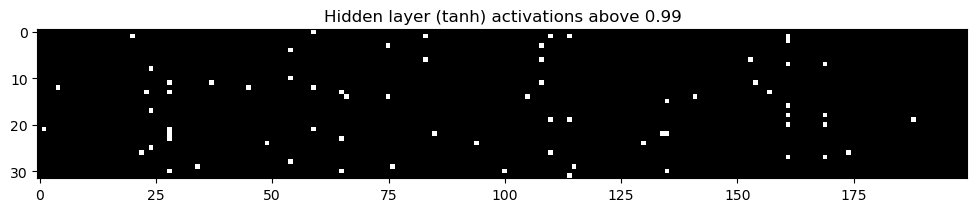

In [23]:
plt.figure(figsize=(12,6))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title("Hidden layer (tanh) activations above 0.99")

#### Summary of Kaiming Initialization

In order to squash our weights into a unitary gaussian, we divide by $ \sqrt{n_{in}} $

## Part 2: Batch Normalization

We have established by our previous fixes that a neural network trains most efficiently when its neurons' activations are neither zero, or high enough that the non-linear `tanh()` gradient is flat.

Thus, we will introduce batch normalization, an approach to manage the activations of a layer of neurons by manipulating the activations to resemble a unit gaussian curve.'

In [24]:
# MLP Revisited

# Hyper parameters
n_embd = 10         # embedding dimensions
n_hidden = 200      # size of hidden layer
eta = 0.1          # learning rate
n_epochs = 100000    # number of epochs
batch_size = 32     # batch size

g = torch.Generator().manual_seed(2147473647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)        # embedding matrix
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1  # input layer
b1 = torch.randn((n_hidden,),                     generator=g) * 0.01 # input bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # output layer
b2 = torch.randn((vocab_size,),                   generator=g) * 0.01 # output bias
bn_gain = torch.ones((n_hidden,))
bn_bias = torch.zeros((n_hidden,))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 12097


In [25]:
etas = []
losses = []
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

Train the network with BatchNorm gain and BatchNorm bias as parameters

In [26]:
for epoch in range(n_epochs):
    # construct batches
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]]
    x = emb.view(emb.shape[0], -1)
    
    # batch normalization
    z_hidden = x @ W1 # + b1 # Bias now handled by batch norms

    # mean
    # ========================================
    # ========== BATCH NORM START ============
    # ========================================
    bn_mean_i = z_hidden.mean(0, keepdim=True)
    bn_std_i = z_hidden.std(0, keepdim=True)
    z_hidden = bn_gain * (z_hidden - bn_mean_i) / bn_std_i + bn_bias

    # update running mean and std with smoothing factor
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bn_mean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bn_std_i

    # forward pass
    h = torch.tanh(z_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    if epoch % (n_epochs // 10) == 0:
        print(f"Epoch {epoch:3d}: loss = {loss.item():.3f}")
    losses.append(loss.log10().item())

    # backward pass
    for p in parameters:
        p.grad = None # flush out gradients

    # backprop
    loss.backward()

    # update parameters
    for p in parameters:
        p.data -= eta * p.grad if epoch < n_epochs // 2 else eta * p.grad * 0.01

Epoch   0: loss = 3.311
Epoch 10000: loss = 2.469
Epoch 20000: loss = 2.466
Epoch 30000: loss = 2.270
Epoch 40000: loss = 2.361
Epoch 50000: loss = 1.882
Epoch 60000: loss = 2.028
Epoch 70000: loss = 1.941
Epoch 80000: loss = 2.491
Epoch 90000: loss = 2.322


Test the network on validation data

In [27]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_valid, Y_valid),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)
    z_hidden = embcat @ W1 + b1
    z_hidden = bn_gain * (z_hidden - bn_mean_i) / bn_std_i + bn_bias
    h = torch.tanh(z_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss = {loss.item():.3f}")
    return loss

split_loss('train')
split_loss('val')

train loss = 2.057
val loss = 2.338


tensor(2.3379)

#### Summary of Batch Normalization

It is used to modify the scale and average of the weights of a layer (change the standard deviation of the weights, or change the width of the gaussian curve of the weights) in order to keep the activation functions within an optimal place for learnability. For example, if the majority of the weighbted activations of a layer are around the edges of a sigmoid or $tanh$ function, or they are all towards one side (positive or negative) of the activation, the Batch Normalization layer will center the average value to zero, and scale the weights such that the weighted and biased inputs form a unit (stdev = 1) gaussian.

Notice: By shifting these weights simply based on the average of the batch, we are actually generating some noise in the data, since each batch doesn't actually represent the entire dataset, so it is picking random weights from the network, and shifting them due to the average of those weights, which means every batch of neurons gets shifted in a different direction, once per epoch.

This actually makes it harder for the net to overfit on the training data, which sort of regularizes the network.

## Part 3: PyTorch-ifying the batch normalization network

### 3.1: Define classes for Linear, BatchNorm1d, and Tanh layers

In [28]:
# random seed
g = torch.Generator().manual_seed(2147473647)



class Linear: 
    """ 
    @brief Linear layer with Kaiming initialization

    @param fan_in (int) number of input features
    @param fan_out (int) number of output features
    @param bias (bool) whether to include bias

    @return None
    """


    def __init__(self, fan_in, fan_out, bias=True):
        """
        @brief Initialize a linear layer with Kaiming initialization

        @param fan_in (int) number of input features
        @param fan_out (int) number of output features
        @param bias (bool) whether to include bias

        @return None
        """
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # Kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None


    def __call__(self, x):
        """
        @brief calculate w * x + b

        @param x (N, D) input to linear layer

        @return weighted and biased (if bias=True) input
        """
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out


    def parameters(self):
        """ 
        @brief return list of parameters

        @return list of parameters
        """
        return [self.weight] + ([] if self.bias is None else [self.bias])



class BatchNorm1d:
    """ 
    Following PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

    @brief Batch normalization layer
    
    @param dim (int) number of features
    @param eps (float) epsilon for numerical stability
    @param momentum (float) momentum for running mean and variance

    @return None
    """


    def __init__(self, dim, eps=1e-5, momentum=0.1):
        """ 
        @brief Initialize batch normalization layer
        
        @param dim (int) number of features
        @param eps (float) epsilon for numerical stability
        @param momentum (float) momentum for running mean and variance
        """
        self.eps = eps
        self.momentum = momentum
        self.training = True # whether in training mode or evaluation mode
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # BatchNorm gain
        self.beta = torch.zeros(dim) # BatchNorm bias
        # buffes (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # scale and shift
        # update running mean and std with smoothing factor
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_std = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out 


    def parameters(self):
        """ 
        @brief return list of parameters

        @return list of parameters
        """
        return [self.gamma, self.beta]



class Tanh:
    """
    @brief Tanh activation function

    @return None
    """
    def __call__(self, x):
        """ 
        # @brief calculate tanh(x)

        @param x (N, D) input to tanh

        @return tanh(x)
        """
        self.out = torch.tanh(x)
        return self.out


    def parameters(self):
        """ 
        @brief return list of parameters
        
        @return list of parameters
        """
        return []

### 3.2: Construct a network from our layers

In [29]:
# hyper-parameters
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147473647) # random seed

# parameters
C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix
layers = [                                         # layers of the network
    Linear(n_embd * block_size, n_hidden, bias=False), Tanh(), # input layer
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 1
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 2
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 3
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 4
    Linear(           n_hidden, vocab_size, bias=False),       # output layer
]


with torch.no_grad():
    # last layer: make less confident to minimize initial loss
    layers[-1].weight *= 0.1
    # all other layers: kaiming initialization gain for tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 # 5/3 # Kaiming iniitalization gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()] # list of parameters
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True

45970


### 3.3 Network optimization

In [30]:
# same optimization as befroe
epochs = 20000
batch_size = 32
lossi = []

for epoch in range(epochs):

    # minibatch construction
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_b, Y_b = X_train[ix], Y_train[ix] # batch X, Y 

    # forward pass
    emb = C[X_b] # embedding lookup
    x = emb.reshape(emb.shape[0], -1) # flatten
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_b) # loss function 

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # retain gradient for backprop AFTER_DEBUG: would take out retain graph> 
        # TODO: Undertsand above
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    eta = 0.1 if epoch < epochs // 2 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -eta * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f'epoch: {epoch}, loss: {loss.item():.3f}')
    lossi.append(loss.log10().item())

    break

epoch: 0, loss: 3.289


## Part 4: Visualize activations and gradients

### 4.2 activations and gradients on iniialization without Kaiming iniialization gain

layer 1 (      Tanh): mean +0.01, std 0.65, saturated: 6.50%
layer 3 (      Tanh): mean -0.01, std 0.50, saturated: 0.12%
layer 5 (      Tanh): mean -0.01, std 0.42, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean +0.01, std 0.31, saturated: 0.00%


Text(0.5, 1.0, 'initial activation distribution without Kaiming initialization gain for tanh')

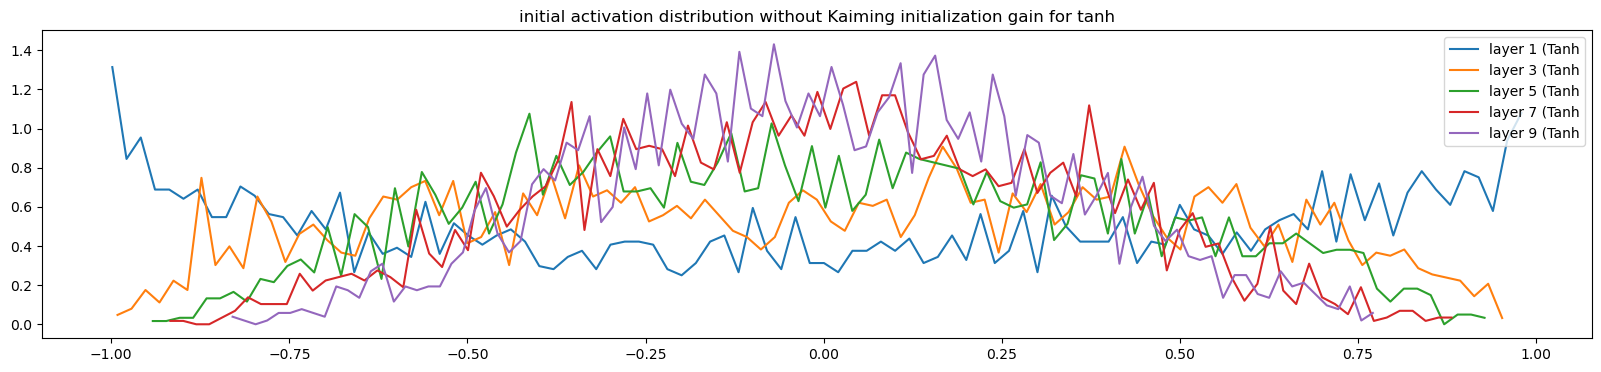

In [31]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('initial activation distribution without Kaiming initialization gain for tanh')

layer 1 (      Tanh): mean +0.000011, std 1.700837e-04
layer 3 (      Tanh): mean +0.000008, std 2.203208e-04
layer 5 (      Tanh): mean -0.000002, std 2.576979e-04
layer 7 (      Tanh): mean -0.000009, std 2.828815e-04
layer 9 (      Tanh): mean -0.000002, std 3.065097e-04


Text(0.5, 1.0, 'vanishing gradient distribution without Kaiming initialization gain for tanh')

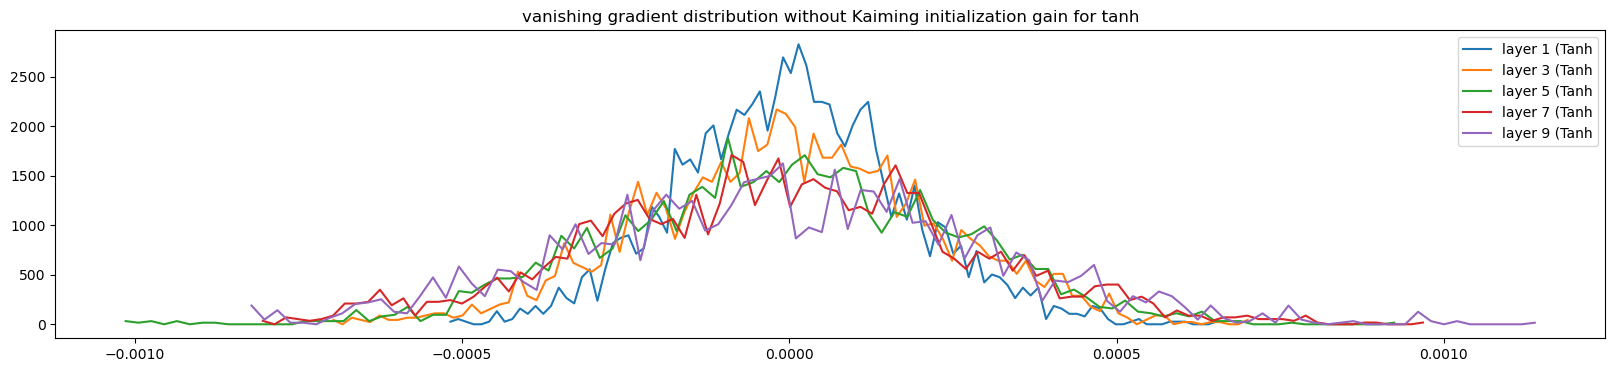

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('vanishing gradient distribution without Kaiming initialization gain for tanh')

### 4.3 now, activations and gradients on iniialization with Kaiming iniialization gain

In [33]:
# hyper-parameters
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147473647) # random seed

# parameters
C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix
layers = [                                         # layers of the network
    Linear(n_embd * block_size, n_hidden, bias=False), Tanh(), # input layer
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 1
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 2
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 3
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 4
    Linear(           n_hidden, vocab_size, bias=False),       # output layer
]


with torch.no_grad():
    # last layer: make less confident to minimize initial loss
    layers[-1].weight *= 0.1
    # all other layers: kaiming initialization gain for tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=  5/3 # Kaiming iniitalization gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()] # list of parameters
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True

45970


In [34]:
# same optimization as befroe
epochs = 20000
batch_size = 32
lossi = []
# reinitialize
for epoch in range(epochs):
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_b, Y_b = X_train[ix], Y_train[ix] # batch X, Y 
    emb = C[X_b] # embedding lookup
    x = emb.reshape(emb.shape[0], -1) # flatten
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_b) # loss function 
    for layer in layers:
        layer.out.retain_grad() # retain gradient for backprop AFTER_DEBUG: would take out retain graph> 
        # TODO: Undertsand above
    for p in parameters:
        p.grad = None
    loss.backward()
    eta = 0.1 if epoch < epochs // 2 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -eta * p.grad
    break

layer 1 (      Tanh): mean +0.02, std 0.77, saturated: 23.72%
layer 3 (      Tanh): mean -0.00, std 0.70, saturated: 10.22%
layer 5 (      Tanh): mean -0.02, std 0.68, saturated: 7.47%
layer 7 (      Tanh): mean +0.00, std 0.65, saturated: 5.56%
layer 9 (      Tanh): mean +0.01, std 0.65, saturated: 4.94%


Text(0.5, 1.0, 'initial activation distribution with Kaiming initialization gain for tanh')

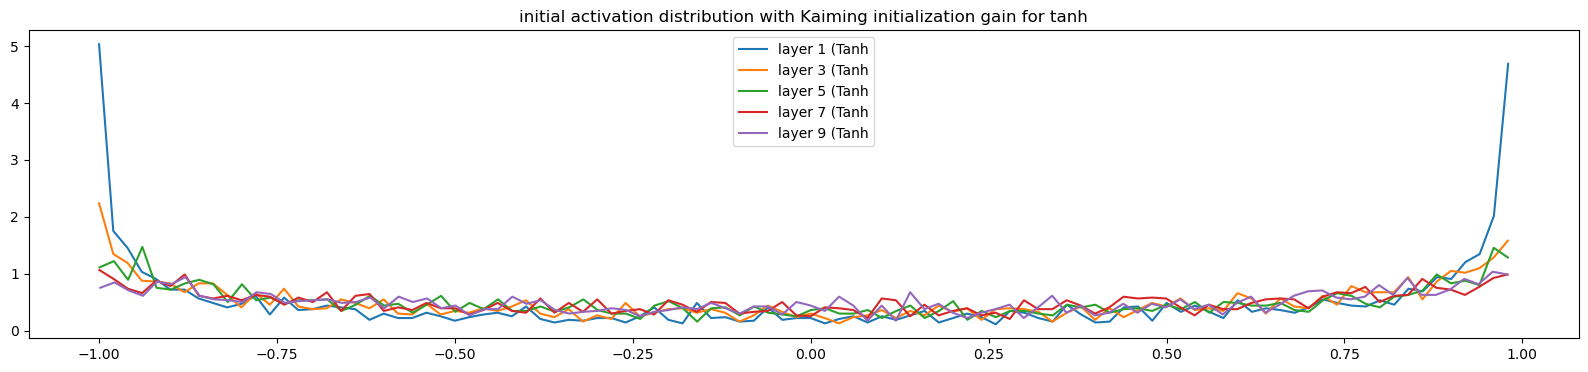

In [35]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('initial activation distribution with Kaiming initialization gain for tanh')

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'initial gradient distribution with Kaiming initialization gain for tanh')

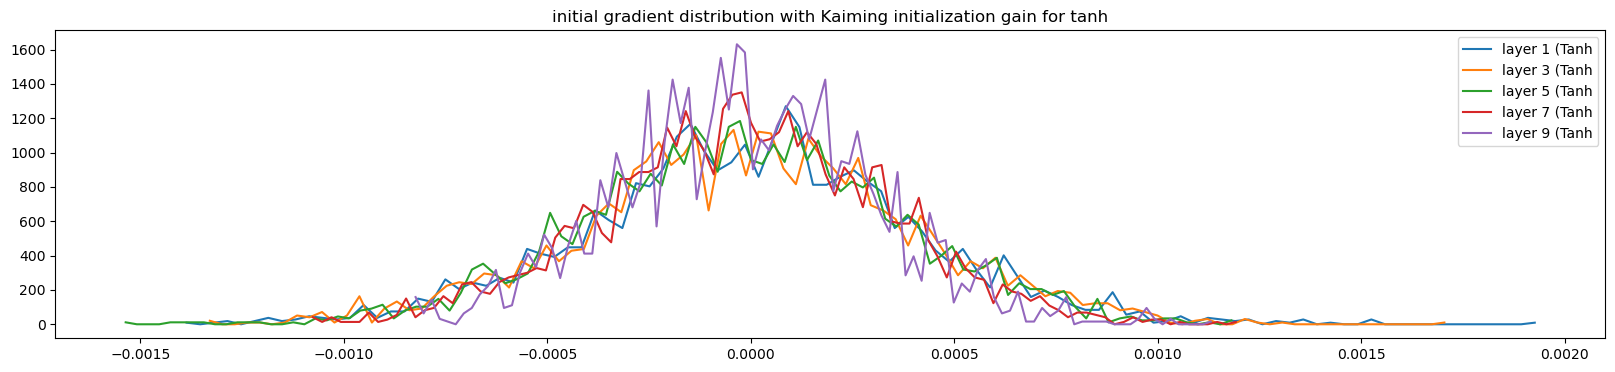

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('initial gradient distribution with Kaiming initialization gain for tanh')


### 5.3: visualizing the update value over epochs

In [37]:
# hyper-parameters
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147473647) # random seed

# parameters
C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix
layers = [                                         # layers of the network
    Linear(n_embd * block_size, n_hidden, bias=False), Tanh(), # input layer
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 1
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 2
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 3
    Linear(           n_hidden, n_hidden, bias=False), Tanh(), # hidden layer 4
    Linear(           n_hidden, vocab_size, bias=False),       # output layer
]


with torch.no_grad():
    # last layer: make less confident to minimize initial loss
    layers[-1].weight *= 0.1
    # all other layers: kaiming initialization gain for tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=  5/3 # Kaiming iniitalization gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()] # list of parameters
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True

45970


In [38]:
# same optimization as befroe
epochs = 20000
batch_size = 32
lossi = []
ud = []

for epoch in range(epochs):

    # minibatch construction
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_b, Y_b = X_train[ix], Y_train[ix] # batch X, Y 

    # forward pass
    emb = C[X_b] # embedding lookup
    x = emb.reshape(emb.shape[0], -1) # flatten
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_b) # loss function 

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # retain gradient for backprop AFTER_DEBUG: would take out retain graph> 
        # TODO: Undertsand above
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    eta = 0.1 if epoch < epochs // 2 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -eta * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f'epoch: {epoch}, loss: {loss.item():.3f}')
    lossi.append(loss.log10().item())

    # track update value : grad / value
    with torch.no_grad():
        ud.append([(eta*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if epoch > 1000:
        break

epoch: 0, loss: 3.301


Text(0.5, 1.0, 'update value (grad / value) for each parameter over batches')

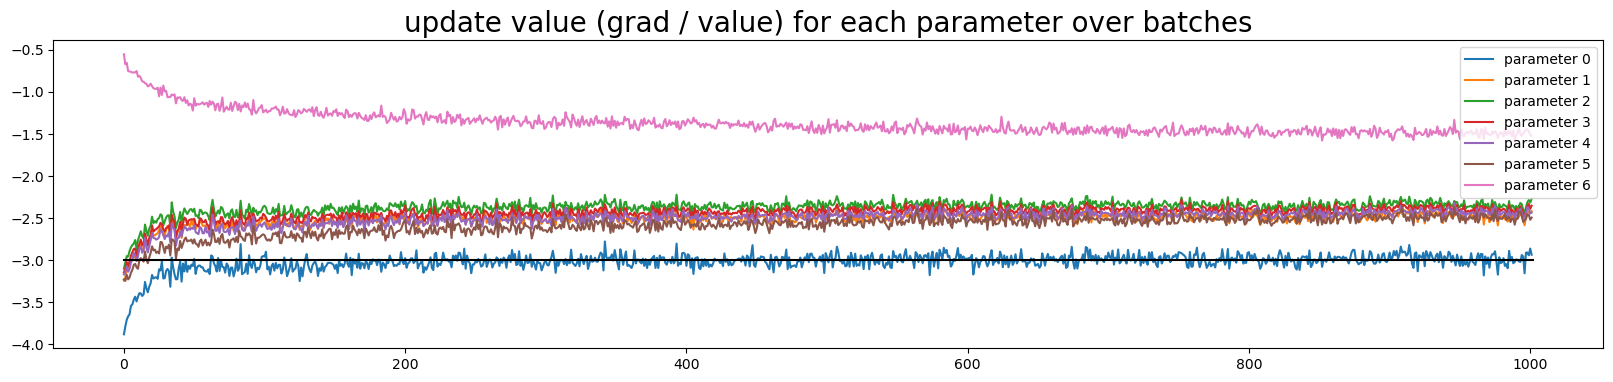

In [39]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))] )
        legends.append(f'parameter {i}')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title("update value (grad / value) for each parameter over batches",fontsize=20)

The output layer weights start very high since we multiplied by 0.1 so that the network was less confident

All of the layers converge towards 1e-3, which is our rough target for how fast we want to be changing the parameters relative to their current value.

## Part 6: Reintroduce batch normalization in PyTorch-ified network to stabilize activations and gradients

In [78]:
# hyper-parameters
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147473647) # random seed

# parameters
C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix
layers = [                                         # layers of the network
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # input layer
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # hidden layer 1
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # hidden layer 2
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # hidden layer 3
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # hidden layer 4
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)       # output layer
]


with torch.no_grad():
    # last layer: make less confident to minimize initial loss
    layers[-1].gamma *= 0.1 # since we use BatchNorm1d, we need to scale gamma instead of weights
    # all other layers: kaiming initialization gain for tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=  5/3 # Kaiming iniitalization gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()] # list of parameters
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True

47024


In [94]:
# same optimization as befroe
epochs = 100000
batch_size = 32
eta = 0.1
lossi = []
ud = []

for epoch in range(epochs):

    # minibatch construction
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_b, Y_b = X_train[ix], Y_train[ix] # batch X, Y 

    # forward pass
    emb = C[X_b] # embedding lookup
    x = emb.reshape(emb.shape[0], -1) # flatten
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_b) # loss function 

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # retain gradient for backprop AFTER_DEBUG: would take out retain graph> 
        # TODO: Undertsand above
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    eta = 0.1 if epoch < epochs // 2 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -eta * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f'epoch: {epoch}, loss: {loss.item():.3f}')
    lossi.append(loss.log10().item())

    # track update value : grad / value
    with torch.no_grad():
        ud.append([(eta*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if epochs > 1000:
        break
    

epoch: 0, loss: 3.291


layer 2 (      Tanh): mean +0.01, std 0.62, saturated: 3.69%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 3.25%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.66%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.78%


Text(0.5, 1.0, 'initial activation distribution when using batch normalization')

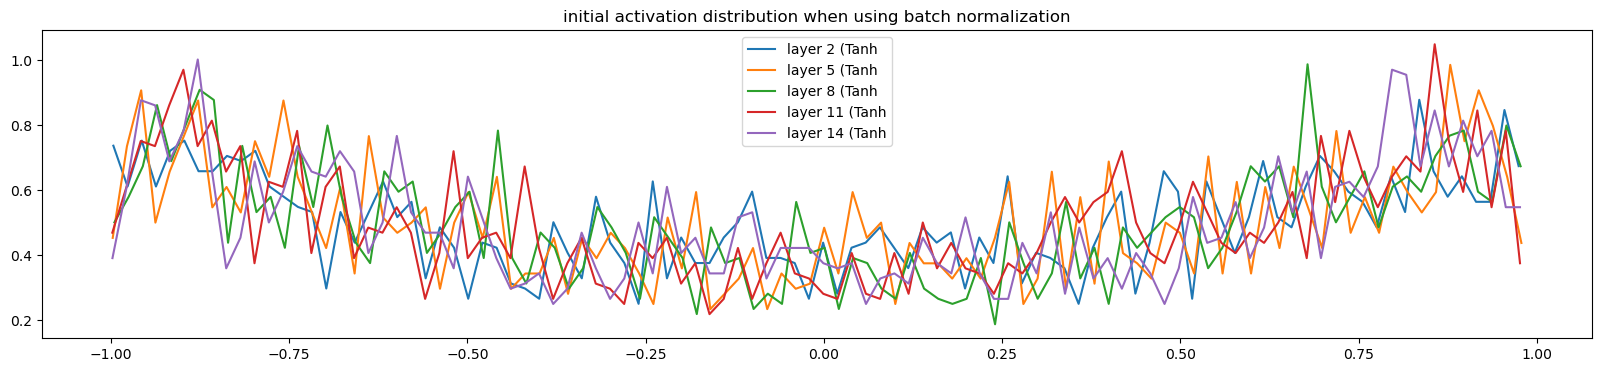

In [80]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('initial activation distribution when using batch normalization')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'initial gradient distribution when using BatchNorm')

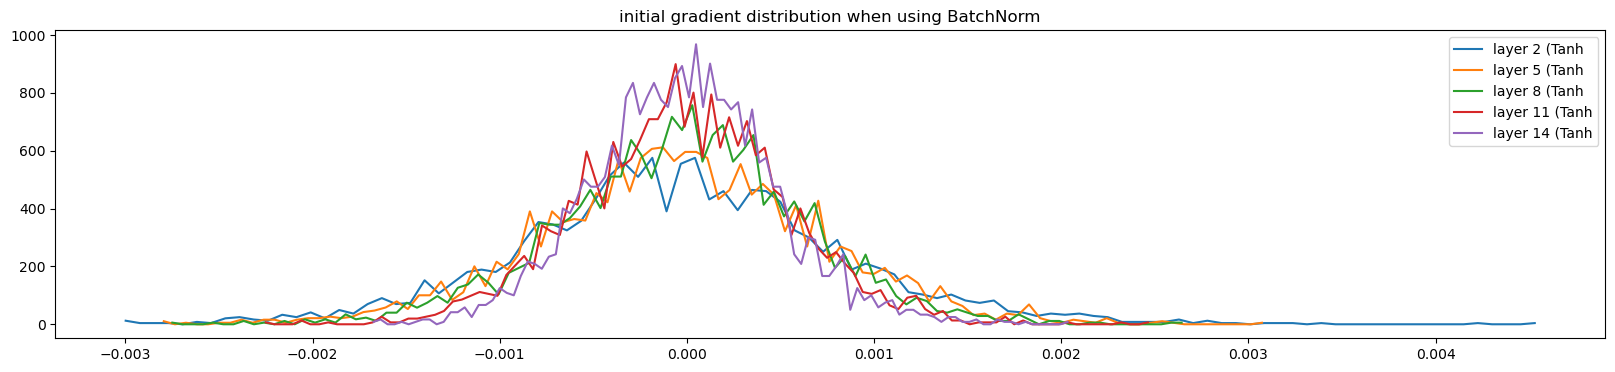

In [84]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('initial gradient distribution when using BatchNorm')
